# pop_bilateral filter with just in time compilation and nogil
Benchmark of scikit-image's pop_bilateral filter (rank cython) vs python jit with numba. 

Numba also allows for easy multiprocessing with releasing the global intepreter lock.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from numba import jit, vectorize
import numpy as np
from skimage.io import imread, imshow
from skimage.filters import rank
from skimage.morphology import square
from scipy import ndimage as ndi

### parallel processing with dask and threading
For more details, see https://github.com/scikit-image/scikit-image/pull/1493

In [29]:
from math import ceil
from multiprocessing import cpu_count
import dask.array as da

def _get_chunks(shape, ncpu):
    chunks = []
    nchunks_per_dim = int(ceil(ncpu ** (1./len(shape))))

    used_chunks = 1
    for i in shape:
        if used_chunks < ncpu:
            regular_chunk = i // nchunks_per_dim
            remainder_chunk = regular_chunk + (i % nchunks_per_dim)

            if regular_chunk == 0:
                chunk_lens = (remainder_chunk,)
            else:
                chunk_lens = ((regular_chunk,) * (nchunks_per_dim - 1) +
                              (remainder_chunk,))
        else:
            chunk_lens = (i,)

        chunks.append(chunk_lens)
        used_chunks *= nchunks_per_dim
    return tuple(chunks)


def apply_chunks(function, array, chunks=None, depth=0, mode=None,
                 extra_arguments=(), extra_keywords={}):
    if chunks is None:
        shape = array.shape
        ncpu = cpu_count()
        chunks = _get_chunks(shape, ncpu)

    if mode == 'wrap':
        mode = 'periodic'

    def wrapped_func(arr):
        return function(arr, *extra_arguments, **extra_keywords)

    darr = da.from_array(array, chunks=chunks)
    return darr.map_overlap(wrapped_func, depth, boundary=mode).compute()

### numba population bilateral

In [30]:
def pop_bilateral(img, selem, s0=10, s1=10, which=None):
    """Simple pop bilateral filter.
    
    Parameters
    ----------
    img : 2d array
    selem : 2d array
        Selem. Only y-shape will be considered, resulting in a square selem.
    s0 : int
        Lower bound.
    s1 : int
        Higher bound.
    """
    img = img.astype(np.int16) # avoid overrun when calculating diff
    pad = selem.shape[0]//2 # square selem for now
    selem_size = 2*pad+1
    out = np.zeros(img.shape, dtype=np.uint8) # nopython, nogil
    img = np.pad(img, ((pad+1, pad), (pad, pad)), mode='edge') # one extra on top
    hist = np.zeros(256)
    _pop_bilateral(img, hist, selem_size, out, s0, s1)
    return out

@jit(nogil=True, nopython=True)
def _pop_bilateral(img, hist, selem_size, out, s0=10, s1=10):
    "Sliding window histogram algo"
    iy, ix = img.shape
    pad = selem_size//2
    # initialize histogram
    for ii in range(selem_size):
        for jj in range(selem_size):
            val = img[ii, jj]
            hist[val] += 1
    
    # every pixel in zick zack
    for i in range(1, iy-2*pad): # rows
        if i%2 == 1: # zick
            r = range(ix-2*pad)
        else: # zack
            r = range(ix-2*pad-1, -1, -1)
        
        for j in r: # cols
            # update hist
            if ((j == 0 and i%2 == 1) or
                (j == ix-2*pad-1 and i%2 == 0)): # row step
                for jj in range(selem_size):
                    v1 = img[i-1, j+jj]
                    v2 = img[i+selem_size-1, j+jj]
                    hist[v1] -= 1
                    hist[v2] += 1
            elif i%2 == 1: # column step forward
                for ii in range(selem_size):
                    v1 = img[i+ii, j-1]
                    v2 = img[i+ii, j+selem_size-1]
                    hist[v1] -= 1
                    hist[v2] += 1
            else: # column step backward
                for ii in range(selem_size):
                    v1 = img[i+ii, j+selem_size]
                    v2 = img[i+ii, j]
                    hist[v1] -= 1
                    hist[v2] += 1
                
            # get out value
            val = img[i+pad, j+pad]
            o = 0
            for h in range(val-s0, val+s1+1):
                if h < 0 or h > 255:
                    continue
                o += hist[h]
            out[i-1, j] = o

### numba mean
implementation from scipy: http://www.phi-node.com/2013/06/faster-morphological-image-filters-in.html

In [31]:
def mean(img, selem):
    """Simple mean filter.
    
    Parameters
    ----------
    img : 2d array
    selem : 2d array
        Selem. Only y-shape will be considered, resulting in a square selem.
    """
    img = img.astype(np.uint32)
    out = np.empty(img.shape, dtype=np.uint8)
    pad = selem.shape[0]//2 # square selem for now
    img = np.pad(img, pad, mode='edge')
    rows = np.zeros(img.shape, dtype=np.uint32) # size of padded
    selem_size = 2*pad+1
    _mean(img, selem_size, rows, out)
    return out


@jit(nopython=True, nogil=True)
def _mean(img, selem_size, rows, out):
    iy, ix = img.shape
    pad = selem_size//2
    for i in range(iy-2*pad):
        for j in range(ix):
            for ii in range(selem_size):
                rows[i, j] += img[i+ii, j]
    # 2n instead of 2^2
    for i in range(iy-2*pad):
        for j in range(ix-2*pad):
            o = 0
            for jj in range(selem_size):
                o += rows[i, j+jj]
            out[i, j] = o // selem_size**2

45 Mega pixels


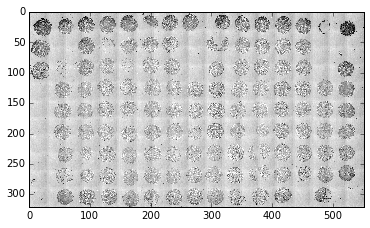

In [32]:
!if [ ! -e stitched--U00--V00--C00--Z00.png ]; then wget https://github.com/arve0/master/raw/master/stitched--U00--V00--C00--Z00.png; fi
img = imread('stitched--U00--V00--C00--Z00.png') # in root of repo github.com/arve0/master
imshow(img[::16, ::16])
mpixels = int(img.shape[0] * img.shape[1] * 1e-6)
print(mpixels, 'Mega pixels')

### pop speed comparison

In [33]:
# skimage
selem_size = 21 # sliding window and convolve performs the same when selem = 11x11
%time pop_sk = rank.pop_bilateral(img, square(selem_size))

CPU times: user 33.7 s, sys: 1.38 s, total: 35.1 s
Wall time: 36.7 s


In [34]:
# numba
%time pop_nb = pop_bilateral(img, square(selem_size))

CPU times: user 8.29 s, sys: 681 ms, total: 8.97 s
Wall time: 9.33 s


In [35]:
# numba parallel with dask threading
%time pop_da = apply_chunks(pop_bilateral, img, depth=4, extra_arguments=(square(selem_size),))

CPU times: user 12.2 s, sys: 1.15 s, total: 13.3 s
Wall time: 4.61 s


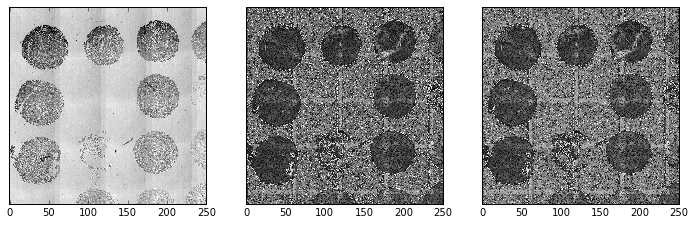

In [36]:
plt.figure(figsize=(12,4))
mask = np.index_exp[:2000:8, :2000:8]
plt.subplot(131)
imshow(img[mask]).axes.set_yticks([])
plt.subplot(132)
imshow(pop_sk[mask]).axes.set_yticks([])
plt.subplot(133)
imshow(pop_nb[mask]).axes.set_yticks([]);

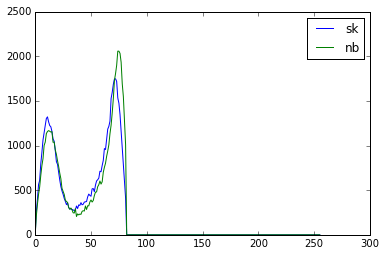

In [10]:
hist_sk = np.zeros(256)
hist_nb = np.zeros(256)
for i in range(256):
    hist_sk[i] = np.sum(pop_sk[mask] == i)
    hist_nb[i] = np.sum(pop_nb[mask] == i)
plt.plot(hist_sk, label="sk")
plt.plot(hist_nb, label="nb")
plt.legend();

### mean speed comparison

In [9]:
# skimage
selem_size = 21 # 2x1D numba implementation outperform the skimage windowing mean filter for all sizes
%time mean_sk = rank.mean(img, square(selem_size))

CPU times: user 21.2 s, sys: 853 ms, total: 22.1 s
Wall time: 22.9 s


In [10]:
# numba mean
%time mean_nb = mean(img, square(selem_size))

CPU times: user 5.3 s, sys: 974 ms, total: 6.28 s
Wall time: 6.66 s


In [11]:
%time mean_ndi = ndi.uniform_filter(img, size=selem_size)

CPU times: user 2.25 s, sys: 89.4 ms, total: 2.33 s
Wall time: 2.37 s


In [12]:
# numba parallel with dask threading
%time mean_da = apply_chunks(mean, img, depth=4, extra_arguments=(square(selem_size),))

CPU times: user 8.48 s, sys: 1.63 s, total: 10.1 s
Wall time: 3.74 s


In [26]:
%time mean_ndi_da = apply_chunks(ndi.uniform_filter, img, depth=selem_size//2, extra_keywords={'size':selem_size})

CPU times: user 3.04 s, sys: 157 ms, total: 3.2 s
Wall time: 1.34 s


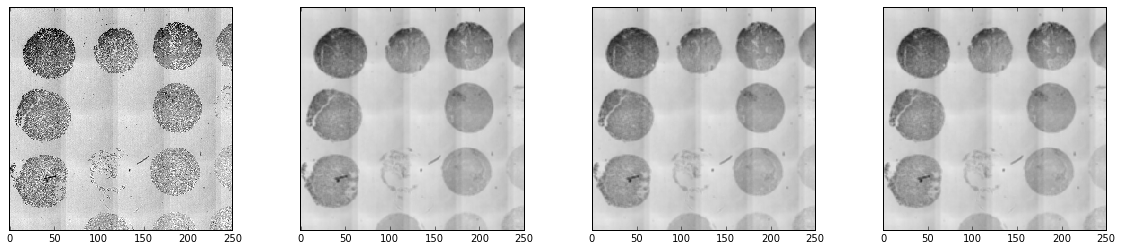

In [27]:
plt.figure(figsize=(20,4))
plt.subplot(141)
imshow(img[mask]).axes.set_yticks([])
plt.subplot(142)
imshow(mean_sk[mask]).axes.set_yticks([])
plt.subplot(143)
imshow(mean_nb[mask]).axes.set_yticks([])
plt.subplot(144)
imshow(mean_ndi_da[mask]).axes.set_yticks([]);

### debug numba

In [15]:
_pop_bilateral.inspect_types()

_pop_bilateral (array(int16, 2d, C), array(float64, 1d, C), int64, array(uint8, 2d, C), int64, int64)
--------------------------------------------------------------------------------
# File: <ipython-input-3-cba51d0967c2>
# --- LINE 23 --- 

@jit(nogil=True, nopython=True)

# --- LINE 24 --- 

def _pop_bilateral(img, hist, selem_size, out, s0=10, s1=10):

    # --- LINE 25 --- 
    # label 0
    #   img = arg(0, name=img)  :: array(int16, 2d, C)
    #   hist = arg(1, name=hist)  :: array(float64, 1d, C)
    #   selem_size = arg(2, name=selem_size)  :: int64
    #   out = arg(3, name=out)  :: array(uint8, 2d, C)
    #   s0 = arg(4, name=s0)  :: int64
    #   s1 = arg(5, name=s1)  :: int64
    #   $0.2 = getattr(value=img, attr=shape)  :: (int64 x 2)
    #   $0.5 = exhaust_iter(value=$0.2, count=2)  :: (int64 x 2)
    #   del $0.2
    #   $0.3 = static_getitem(index=0, value=$0.5)  :: int64
    #   $0.4 = static_getitem(index=1, value=$0.5)  :: int64
    #   del $0.5
    #   iy = $0.3  :